In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from datetime import date
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../load_data')
from load import load_stats, load_history

pd.options.mode.chained_assignment = None

# Load Data

In [2]:
players = load_stats()
history = load_history()

# Clean Data

In [3]:
# valid player defined as players who didn't gain more than 1500 points in their first tournament
def valid_player(player):
    r_hist = history[history['Database#'] == player['Database#']]
    if len(r_hist) == 0:
        return False

    first_tournament = r_hist.iloc[-1]
    return first_tournament['Final Rating'] <= 1500

# filter out people who don't have initial ratings or start dates
history = history.dropna(subset=["Initial Rating", "Start Date"])
players = players[players['Database#'].isin(history['Database#'])]

# filter out all invalid players
players['Valid Player'] = players.apply(valid_player, axis=1)
valid = players[['Database#', 'Valid Player']]
history = history.merge(valid, how='inner', on='Database#')
players = players[players['Valid Player'] == True].reset_index(drop=True)
history = history[history['Valid Player'] == True].reset_index(drop=True)

# Analyze Data

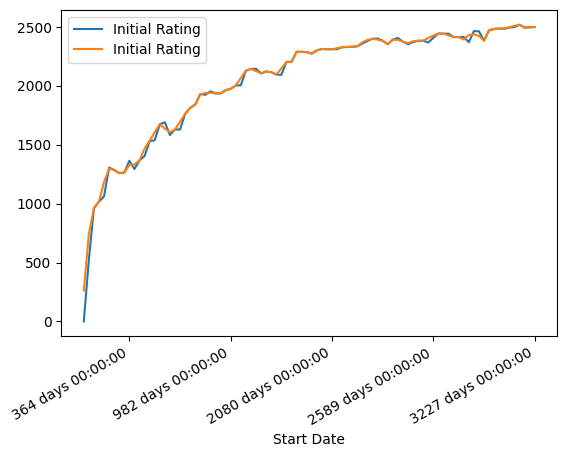

In [4]:
me = history[history['Database#'] == 102103]
myhist = pd.DataFrame(me['Initial Rating'])
myhist.index = me['Start Date'] - me['Start Date'].iloc[-1]

ax = plt.axes()
myhist.plot(ax=ax).invert_xaxis()
myhist.rolling('30d').mean().plot(ax=ax)
plt.show()

<Axes: >

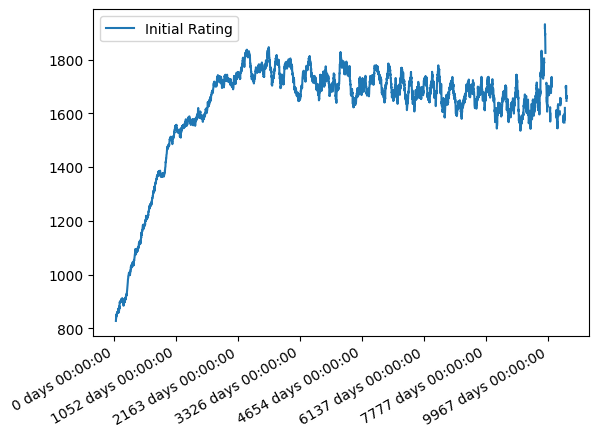

In [5]:
def start_date(id):
    rhist = history[history['Database#'] == id['Database#']]
    return rhist['Start Date'].iloc[-1]

uniqueids = pd.DataFrame(history['Database#'].unique(), columns=['Database#'])
startdates = uniqueids.apply(start_date, axis=1)
startdates.index = uniqueids['Database#']
allhist = pd.DataFrame(history['Initial Rating'])
allhist.index = history['Start Date'].reset_index(drop=True) - startdates[history['Database#']].reset_index(drop=True)
allhist = allhist.sort_index()
avghist = allhist.groupby(allhist.index).mean()
avghist.rolling('90d', min_periods=30).mean().plot()

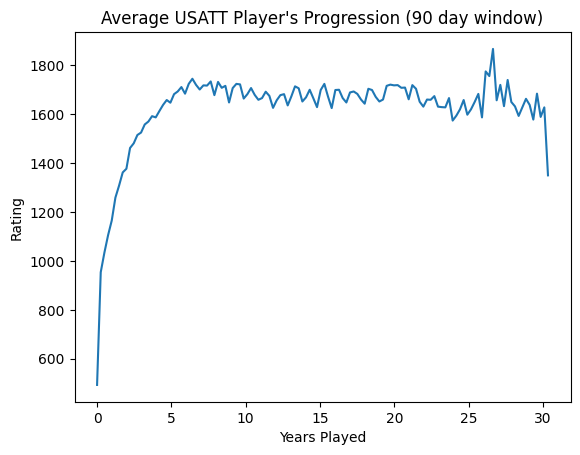

In [6]:
window = 90

def gen_window(player, window):
    hist = history[history['Database#'] == player['Database#']]
    rhist = pd.DataFrame(hist['Initial Rating'])
    rhist.index = hist['Start Date'] - hist['Start Date'].iloc[-1]
    return rhist.rolling(f'{window}d').mean()

def avg_player(population):
    population['rolling'] = population.apply(gen_window, axis=1, args=[window])
    total = pd.concat(population['rolling'].to_list()).sort_index()

    bins = pd.to_timedelta([f'{i}d' for i in range(0, total.index.max().days+window, window)])
    total['Years Played'] = pd.cut(total.index, bins, labels=bins[:-1].days/365, include_lowest=True)
    return total.groupby('Years Played', observed=True).mean().reset_index().astype({'Years Played': float, 'Initial Rating': int})

all_avg = avg_player(players)
plt.plot(all_avg['Years Played'], all_avg['Initial Rating'])
plt.title(f"Average USATT Player's Progression ({window} day window)")
plt.xlabel('Years Played')
plt.ylabel('Rating')
plt.show()

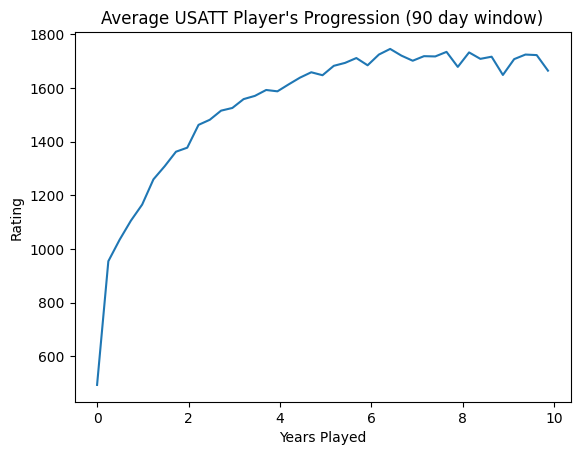

In [7]:
all_avg_10y = all_avg[all_avg['Years Played'] < 10]
plt.plot(all_avg_10y['Years Played'], all_avg_10y['Initial Rating'])
plt.title(f"Average USATT Player's Progression ({window} day window)")
plt.xlabel('Years Played')
plt.ylabel('Rating')
plt.show()

<Axes: xlabel='Years Played', ylabel='Initial Rating'>

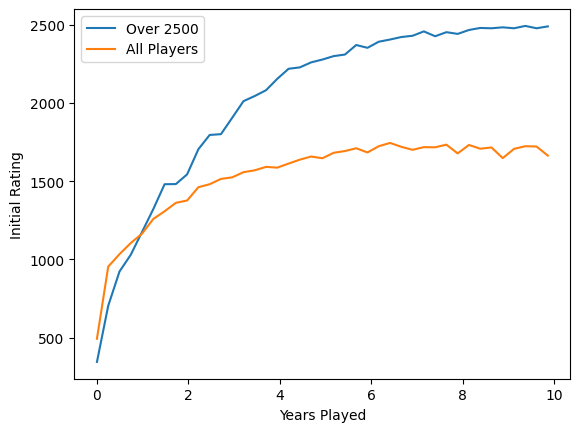

In [15]:
rating_cutoff = 2500
fplayers = players[players['Tournament Rating'] > rating_cutoff]
avg_2500 = avg_player(fplayers)
avg_2500_10y = avg_2500[avg_2500['Years Played'] < 10]

ax = plt.axes()
avg_2500_10y.plot(ax=ax, x='Years Played', y='Initial Rating', ylabel='Initial Rating', label=f'Over {rating_cutoff}')
all_avg_10y.plot(ax=ax, x='Years Played', y='Initial Rating', label='All Players')